# Check ss with noise

In [1]:
#FLAT VS SS 3K2R3P
### IMPORT PACKAGES AND ALSO REWRITE FUNCTIONS ###

import torch
import multiprocessing
import os

def get_gpu_count():
    return torch.cuda.device_count()

def get_cpu_count():
    return multiprocessing.cpu_count()

if __name__ == "__main__":
    num_gpus = get_gpu_count()
    num_cpus = get_cpu_count()
    print("Number of GPUs (torch.cuda.device_count()):", num_gpus)
    print("Number of CPUs (multiprocessing.cpu_count()):", num_cpus)

print("Number of CPUs (os.cpu_count()):", os.cpu_count())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np

import joblib
import math
from math import ceil
import random
import contextlib
import torch
import sys
from numpy import fft, ndarray
from scipy.stats import norm
import os
import seaborn as sns
from pyro.infer.mcmc.api import MCMC
from warnings import warn
from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union, Dict
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm, trange
from pyro.infer.mcmc import HMC, NUTS
from sbi.inference import prepare_for_sbi, SNLE
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.types import Shape, TorchTransform
from sbi.utils.get_nn_models import (likelihood_nn,)
from sbi.samplers.mcmc import SliceSamplerVectorized
from sbi.samplers.mcmc.slice_numpy import MCMCSampler
from sbi.utils import tensor2numpy

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(10_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)
    
    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress
    
    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

class SliceSampler(MCMCSampler):
    def __init__(self, x, lp_f, max_width=float("inf"), init_width: Union[float, np.ndarray] = 0.05, thin=None, tuning: int = 50, verbose: bool = False,):
        MCMCSampler.__init__(self, x, lp_f, thin, verbose=verbose)
        self.max_width = max_width
        self.init_width = init_width
        self.width = None
        self.tuning = tuning
        
    def _tune_bracket_width(self, rng):
        order = list(range(self.n_dims))
        x = self.x.copy()

        self.width = np.full(self.n_dims, self.init_width)

        tbar = trange(self.tuning, miniters=2, disable=not self.verbose)
        tbar.set_description("Tuning bracket width...")
        for n in tbar:
            # for n in range(int(self.tuning)):
            rng.shuffle(order)
            for i in range(self.n_dims):
                x[i], wi = self._sample_from_conditional(i, x[i], rng)
                self.width[i] += (wi - self.width[i]) / (n + 1)

    def _sample_from_conditional(self, i: int, cxi, rng):
        assert self.width is not None, "Chain not initialized."

        # conditional log prob
        Li = lambda t: self.lp_f(np.concatenate([self.x[:i], [t], self.x[i + 1 :]]))
        wi = self.width[i]

        # sample a slice uniformly
        logu = Li(cxi) + np.log(1.0 - rng.rand())

        # position the bracket randomly around the current sample
        lx = cxi - wi * rng.rand()
        ux = lx + wi
        
        # find lower bracket end
        while Li(lx) >= logu and cxi - lx < self.max_width:
            lx -= wi

        # find upper bracket end
        while Li(ux) >= logu and ux - cxi < self.max_width:
            ux += wi

        # sample uniformly from bracket
        xi = (ux - lx) * rng.rand() + lx

        # if outside slice, reject sample and shrink bracket
        while Li(xi) < logu:
            if xi < cxi:
                lx = xi
            else:
                ux = xi
            xi = (ux - lx) * rng.rand() + lx
       
        return xi, ux - lx
      
def run_fun(SliceSamplerSerial, num_samples, inits, seed, log_prob_fn: Callable, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01,
            max_width: float = float("inf"), num_workers: int = 1, rng=np.random, show_info: bool = False, logger=sys.stdout) -> np.ndarray:
    np.random.seed(seed)
    posterior_sampler = SliceSampler(inits, lp_f=log_prob_fn, max_width=max_width, init_width=init_width, thin=thin, tuning=tuning, verbose=num_workers == 1 and verbose,)
    
    assert num_samples >= 0, "number of samples can't be negative"

    order = list(range(posterior_sampler.n_dims))
    L_trace = []
    samples = np.empty([int(num_samples), int(posterior_sampler.n_dims)])
    logger = open(os.devnull, "w") if logger is None else logger

    if posterior_sampler.width is None:
        # logger.write('tuning bracket width...\n')
        posterior_sampler._tune_bracket_width(rng)

    tbar = trange(int(num_samples), miniters=10, disable=not posterior_sampler.verbose)
    tbar.set_description("Generating samples")
    for n in tbar:
        # for n in range(int(n_samples)):
        for _ in range(posterior_sampler.thin):
            rng.shuffle(order)

            for i in order:
                posterior_sampler.x[i], _ = posterior_sampler._sample_from_conditional(i, posterior_sampler.x[i], rng)

        samples[n] = posterior_sampler.x.copy()

        posterior_sampler.L = posterior_sampler.lp_f(posterior_sampler.x)
        # logger.write('sample = {0}, log prob = {1:.2}\n'.format(n+1, self.L))

        if show_info:
            L_trace.append(posterior_sampler.L)

    # show trace plot
    if show_info:
        fig, ax = plt.subplots(1, 1)
        ax.plot(L_trace)
        ax.set_ylabel("log probability")
        ax.set_xlabel("samples")
        plt.show(block=False)

    return samples

def run(SliceSamplerSerial, log_prob_fn: Callable, num_samples: int, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, verbose: bool = True, num_workers: int = 1,) -> np.ndarray:
    num_chains , dim_samples = init_params.shape
    # Generate seeds for workers from current random state.
    seeds = torch.randint(high=1_000_000, size=(num_chains,))
    for seed in seeds:
        seed_all_backends(seed)
    with tqdm_joblib(tqdm(range(num_chains), disable=not verbose, desc=f"""Running {num_chains} MCMC chains with {num_workers} worker{"s" if num_workers>1 else ""}.""", total=num_chains,)):
        all_samples = Parallel(n_jobs=num_workers)(delayed(run_fun)(SliceSamplerSerial, num_samples, initial_params_batch, seed, log_prob_fn)for initial_params_batch, seed in zip(init_params, seeds))
    samples = np.stack(all_samples).astype(np.float32)
    samples = samples.reshape(num_chains, -1, dim_samples)  # chains, samples, dim
    samples = samples[:, :: thin, :]  # thin chains

    # save samples
    return samples

class SliceSamplerSerial:
    def __init__(self, log_prob_fn: Callable, init_params: np.ndarray, num_chains: int = 1, thin: Optional[int] = None, tuning: int = 50, verbose: bool = True, init_width: Union[float, np.ndarray] = 0.01, max_width: float = float("inf"), num_workers: int = 1,):
        self._log_prob_fn = log_prob_fn
        self.x = init_params
        self.num_chains = num_chains
        self.thin = thin
        self.tuning = tuning
        self.verbose = verbose
        self.init_width = init_width
        self.max_width = max_width
        self.n_dims = self.x.size
        self.num_workers = num_workers
        self._samples = None

    def get_samples(self, num_samples: Optional[int] = None, group_by_chain: bool = True) -> np.ndarray:
        if self._samples is None:
            raise ValueError("No samples found from MCMC run.")
        # if not grouped by chain, flatten samples into (all_samples, dim_params)
        if not group_by_chain:
            samples = self._samples.reshape(-1, self._samples.shape[2])
        else:
            samples = self._samples

        # if not specified return all samples
        if num_samples is None:
            return samples
        # otherwise return last num_samples (for each chain when grouped).
        elif group_by_chain:
            return samples[:, -num_samples:, :]
        else:
            return samples[-num_samples:, :]

##############################################################################################################################
        
def _maybe_use_dict_entry(default: Any, key: str, dict_to_check: Dict) -> Any:
    attribute = default if key not in dict_to_check.keys() else dict_to_check[key]
    return attribute

def _get_initial_params(proposal, init_strategy: str, num_chains: int, num_workers: int, show_progress_bars: bool, **kwargs,) -> Tensor: 
    # Build init function
    init_fn = proposal._build_mcmc_init_fn(proposal.proposal, proposal.potential_fn, transform=proposal.theta_transform, init_strategy=init_strategy, **kwargs,)

    # Parallelize inits for resampling only.
    if num_workers > 1 and (init_strategy == "resample" or init_strategy == "sir"):
        def seeded_init_fn(seed):
            torch.manual_seed(seed)
            return init_fn()

        seeds = torch.randint(high=10_000_000, size=(num_chains,))

        # Generate initial params parallelized over num_workers.
        with tqdm_joblib(tqdm(range(num_chains), disable=not show_progress_bars, desc=f"""Generating {num_chains} MCMC inits with {num_workers} workers.""", total=num_chains,)):
            initial_params = torch.cat(Parallel(n_jobs=num_workers)(delayed(seeded_init_fn)(seed) for seed in seeds))
    else:
        initial_params = torch.cat([init_fn() for _ in range(num_chains)])
    return initial_params
    
def _slice_np_mcmc(proposal, num_samples: int, potential_function: Callable, initial_params: Tensor, thin: int, warmup_steps: int, vectorized: bool = False, num_workers: int = 1, init_width: Union[float, ndarray] = 0.01, show_progress_bars: bool = True,) -> Tensor:
    num_chains, dim_samples = initial_params.shape
        
    if not vectorized:
        SliceSamplerMultiChain = SliceSamplerSerial
    else:
        SliceSamplerMultiChain = SliceSamplerVectorized

    posterior_sampler = SliceSamplerMultiChain(init_params=tensor2numpy(initial_params), log_prob_fn=potential_function, num_chains=num_chains, thin=thin, verbose=show_progress_bars, num_workers=num_workers, init_width=init_width,)
    warmup_ = warmup_steps * thin
    num_samples_ = ceil((num_samples * thin) / num_chains)
    # Run mcmc including warmup
    samples = run(posterior_sampler, log_prob_fn=potential_function, num_samples = (warmup_ + num_samples_), init_params = tensor2numpy(initial_params))
    samples = samples[:, warmup_steps:, :]  # discard warmup steps
    samples = torch.from_numpy(samples)  # chains x samples x dim

    # Save posterior sampler.
    proposal._posterior_sampler = posterior_sampler

    # Save sample as potential next init (if init_strategy == 'latest_sample').
    proposal._mcmc_init_params = samples[:, -1, :].reshape(num_chains, dim_samples)

    # Collect samples from all chains.
    samples = samples.reshape(-1, dim_samples)[:num_samples, :]
    assert samples.shape[0] == num_samples
    return samples.type(torch.float32).to(proposal._device)

def sample_my_fun(proposal, sample_shape: Shape = torch.Size(), x: Optional[Tensor] = None, method: Optional[str] = None, thin: Optional[int] = None, warmup_steps: Optional[int] = None, num_chains: Optional[int] = None, init_strategy: Optional[str] = None, init_strategy_parameters: Optional[Dict[str, Any]] = None,
                   init_strategy_num_candidates: Optional[int] = None, mcmc_parameters: Dict = {}, mcmc_method: Optional[str] = None, sample_with: Optional[str] = None, num_workers: Optional[int] = None, show_progress_bars: bool = True,) -> Tensor:
    
    proposal.potential_fn.set_x(proposal._x_else_default_x(x))

    # Replace arguments that were not passed with their default.
    method = proposal.method if method is None else method
    thin = proposal.thin if thin is None else thin
    warmup_steps = proposal.warmup_steps if warmup_steps is None else warmup_steps
    num_chains = proposal.num_chains if num_chains is None else num_chains
    init_strategy = proposal.init_strategy if init_strategy is None else init_strategy
    num_workers = proposal.num_workers if num_workers is None else num_workers
    init_strategy_parameters = (proposal.init_strategy_parameters if init_strategy_parameters is None else init_strategy_parameters)

    if init_strategy_num_candidates is not None:
        warn("""Passing `init_strategy_num_candidates` is deprecated as of sbi v0.19.0. Instead, use e.g.,`init_strategy_parameters={"num_candidate_samples": 1000}`""")
        proposal.init_strategy_parameters["num_candidate_samples"] = (init_strategy_num_candidates)
    if sample_with is not None:
        raise ValueError(f"You set `sample_with={sample_with}`. As of sbi v0.18.0, setting `sample_with` is no longer supported. You have to rerun `.build_posterior(sample_with={sample_with}).`")
    if mcmc_method is not None:
        warn("You passed `mcmc_method` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Use `method` instead of `mcmc_method`.")
        method = mcmc_method
    if mcmc_parameters:
        warn("You passed `mcmc_parameters` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Instead, pass the variable to `.sample()` directly, e.g. `posterior.sample((1,), num_chains=5)`.")
    # The following lines are only for backwards compatibility with sbi v0.17.2 or older.
    m_p = mcmc_parameters  # define to shorten the variable name
    method = _maybe_use_dict_entry(method, "mcmc_method", m_p)
    thin = _maybe_use_dict_entry(thin, "thin", m_p)
    warmup_steps = _maybe_use_dict_entry(warmup_steps, "warmup_steps", m_p)
    num_chains = _maybe_use_dict_entry(num_chains, "num_chains", m_p)
    init_strategy = _maybe_use_dict_entry(init_strategy, "init_strategy", m_p)
    proposal.potential_ = proposal._prepare_potential(method)  # type: ignore

    initial_params = _get_initial_params(proposal, init_strategy, num_chains, num_workers, show_progress_bars, **init_strategy_parameters,)
    num_samples = torch.Size(sample_shape).numel()

    track_gradients = method in ("hmc", "nuts")
    with torch.set_grad_enabled(track_gradients):
        if method in ("slice_np", "slice_np_vectorized"):
            transformed_samples = _slice_np_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, thin=thin, warmup_steps=warmup_steps, vectorized=(method == "slice_np_vectorized"), num_workers=num_workers, show_progress_bars=show_progress_bars,)
        elif method in ("hmc", "nuts", "slice"):
            transformed_samples = _pyro_mcmc(proposal, num_samples=num_samples, potential_function=proposal.potential_, initial_params=initial_params, mcmc_method=method, thin=thin, warmup_steps=warmup_steps, num_chains=num_chains, show_progress_bars=show_progress_bars,)
        else:
            raise NameError

    samples = proposal.theta_transform.inv(transformed_samples)

    return samples.reshape((*sample_shape, -1))  # type: ignore

#######################################################################################################################################

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1 , seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:
    num_sims, *_ = theta.shape
    seed_all_backends(seed)
    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)
        
        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))
            with tqdm_joblib(tqdm(batches, disable=not show_progress_bars, total = len(batches), desc=f"Running {num_sims} simulations in {len(batches)} batches ({num_workers} cores)",)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed) for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )
            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)
        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)
    return x

def simulate_for_sbi(round_idx: int, simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1, simulation_batch_size: int = 1, seed: Optional[int] = None, show_progress_bar: bool = True)-> Tuple[Tensor, Tensor]:
    if round_idx == 0:
        theta = proposal.sample((num_simulations,))
    else:
        theta = sample_my_fun(proposal, (num_simulations,), num_workers = num_workers, num_chains = 4) # because only in first round proposal is boxuniform, then it is mcmcposterior object
    
    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size, num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar)
    
    return theta, x

### Parallelisation ###
##### paralellise #####

#Parallelise it
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

######### Encode summary statistics for 3 params


Number of GPUs (torch.cuda.device_count()): 0
Number of CPUs (multiprocessing.cpu_count()): 8
Number of CPUs (os.cpu_count()): 8


In [38]:

###### Simulate
headers = ["k1" , "k2", "k3"]          # parameters to be inferred
num_timesteps = 100

# FOR SNLE
prior_min = 0.01                        # same for all parameters
prior_max = 250    

t = np.linspace(0, 100, num_timesteps)

param_dict = {'k1': 38.94801652652866, 'k2': 193.4015439096185, 'k3': 52.24130352947285, 
              'n1': 4.758094367378883, 'n2': 1.985417765709296, 'n3': 4.910007465597671, 
              'dm1': 1.1977430229572492, 'dm2': 1.5302375124759988, 'dm3': 1.5608364378206137, 
              'dp1': 0.7747339528650133, 'dp2': 0.7511393265314563, 'dp3': 0.7528339378453786,
              'a1': 30.52123007653054, 'a2': 39.231588311273846, 'a3': 34.86007101736975, 
              'g1': 0.1902661176643755, 'g2': 0.28113643328037285, 'g3': 0.8181176651249633, 
              'b1': 24.68491191280538, 'b2': 29.42387320898578, 'b3': 41.04934603816582}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        yt = torch.tensor(y, dtype=torch.float32).T.flatten()
        return yt.unsqueeze(-1)
    return solve_ode(theta, t)
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.]))
true_params = tuple(param_dict[parameter] for parameter in headers)

def model(variables, t, theta, new_param_dict = new_param_dict):
    m1, p1, m2, p2, m3, p3 = variables
    for i in range(len(headers)):
        new_param_dict[headers[i]] = theta[i]
    
    dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
    dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
    dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
    dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
    dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
    dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

def solve_ode(theta, t):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    y = odeint(model, initial_conditions, t, args=(theta,))
    yt = torch.tensor(y, dtype=torch.float32).T.flatten()
    return yt.unsqueeze(-1)

timepoints = int(100)
third = int(timepoints / 3)

from scipy.signal import find_peaks
initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)

def summarise(solution):
    """Calculate summary statistics
        requires solution to be the result of calling solve_ode[parameters]
        e.g. true_data
        Returns
        -------
        a 1D array of summary statistics containing the mean of solution, the log variance of solution, the autocorrelation at lag 10, cross correlation of mRNA and protein species separately, number of peaks
        """
    mean=np.mean(solution, axis=0)
    var=np.var(solution, axis=0)
    #The autocorrelation coefficient of each time series at lag 10 and lag 5
    #can be altered
    auto_cor=np.corrcoef(solution[10:,:], solution[:-10,:], rowvar=False)[6:,:]
    auto_cor_coef=np.diag(auto_cor)
    cor=np.corrcoef(solution, solution, rowvar=False)[:6,2:8]
    cor_coef=np.diag(cor)
    #returning cross correlation coefficients of mRNA to mRNA species, protein to protein species
    truncated_trajectory=solution[third:timepoints,:]
    peaks,_=zip(*(find_peaks(truncated_trajectory[:,i], height=0) for i in range(6)))
    peak_count=np.array([len(p) for p in peaks])
    return(np.concatenate([mean, var, auto_cor_coef, cor_coef, peak_count.flatten()]))

def find_mean_std(num_samples):
    """a function that returns the mean and standard deviation of the summary statistics of the simulated data, for the number of samples specified"""
#generate an empty np array to store simulated data
    simulated_arr=np.zeros((num_samples, 30))
    for i in range(num_samples):
        params_val= np.random.default_rng().uniform(0.01,250,3).flatten() # np.concatenate((np.random.default_rng().uniform(0.01,250,3),np.random.default_rng().uniform(20.,40.,3))).flatten()
        simulated_data= odeint(model, initial_conditions, t, args=(params_val,))
        simulated_arr[i,:]=summarise(simulated_data)
    s_std=np.std(simulated_arr, axis=0)
    s_mean=np.mean(simulated_arr, axis=0)
    return(s_mean, s_std)

m1,s1=find_mean_std(10000)

def normalise(sum_stats, mean, std):
    """takes in sum stats of 1 by 30 array, mean and std are both 1 by 30 arrays, normalise data by the empirically calculated mean and std"""
    normalised=(sum_stats-mean)/std
    return(normalised)

def my_simulator_ss(theta):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    solution = odeint(model, initial_conditions, t, args=(theta,))
    summarised_data = summarise(solution)
    #normalised_ss=normalise(summarised_data, m1, s1)
    return torch.tensor(summarised_data, dtype=torch.float32) 

def my_simulator_ss_noise(theta):
    def solve_ode_t(params, t):
        seed = 12
        np.random.seed(seed)
        initial_conditions = np.array([0.0, 2.0, 0.0, 1.0, 0.0, 3.0])
        solution = odeint(model, initial_conditions, t, args=(params,))
        noise = solution * 0.05
        solution += np.random.normal(0, noise)
        y = np.maximum(solution, 0)
        ## yt = torch.tensor(y, dtype=torch.float32) #.T.flatten()
        return y
    solution = solve_ode_t(theta, t)
    summarised_data = summarise(solution)
    #normalised_ss=normalise(summarised_data, m1, s1)
    return torch.tensor(summarised_data, dtype=torch.float32) 

x_o = my_simulator_ss_noise(true_params) # Generate observations,with data from 100 timepoints for each of 6 variables
prior = utils.BoxUniform(
    low=torch.tensor([10**-2,10**-2,10**-2]),
    high=torch.tensor([250.,250.,250.])
)
simulator, prior = prepare_for_sbi(my_simulator_ss, prior) 

In [58]:
param_dict = {'k1': 38.94801652652866, 'k2': 193.4015439096185, 'k3': 52.24130352947285, 
              'n1': 4.758094367378883, 'n2': 1.985417765709296, 'n3': 4.910007465597671, 
              'dm1': 1.1977430229572492, 'dm2': 1.5302375124759988, 'dm3': 1.5608364378206137, 
              'dp1': 0.7747339528650133, 'dp2': 0.7511393265314563, 'dp3': 0.7528339378453786,
              'a1': 30.52123007653054, 'a2': 39.231588311273846, 'a3': 34.86007101736975, 
              'g1': 0.1902661176643755, 'g2': 0.28113643328037285, 'g3': 0.8181176651249633, 
              'b1': 24.68491191280538, 'b2': 29.42387320898578, 'b3': 41.04934603816582}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param]
    elif param in headers:
        new_param_dict[param] = param

new_param_dict

{'a1': 'a1',
 'a2': 'a2',
 'a3': 'a3',
 'g1': 0.1902661176643755,
 'g2': 0.28113643328037285,
 'g3': 0.8181176651249633,
 'dm1': 1.1977430229572492,
 'dm2': 1.5302375124759988,
 'dm3': 1.5608364378206137,
 'dp1': 0.7747339528650133,
 'dp2': 0.7511393265314563,
 'dp3': 0.7528339378453786,
 'b1': 24.68491191280538,
 'b2': 29.42387320898578,
 'b3': 41.04934603816582,
 'n1': 4.758094367378883,
 'n2': 1.985417765709296,
 'n3': 4.910007465597671,
 'k1': 'k1',
 'k2': 'k2',
 'k3': 'k3'}

In [6]:
headers = ["k1" , "k2", "k3", "a1", "a2", "a3"]   
param_dict = {'k1': [38.94801652652866, 235.67119760518563, 53.43422683264264, 210.46241661118478, 157.56859296717408], 
              'k2': [193.4015439096185, 62.300047733673196, 162.8944039966027, 164.54234707934688, 161.12401803976692], 
              'k3': [52.24130352947285, 220.6962983853205, 232.0323641105102, 156.15245732751265, 98.57067950243771], 
              'n1': [4.758094367378883, 4.70022357188137, 2.5553665378046975, 3.3430542986784277, 1.7981317619294797], 
              'n2': [1.985417765709296, 1.6952398946964649, 4.89313818145526, 4.97420433688225, 4.777383249560577], 
              'n3': [4.910007465597671, 4.042164404491105, 3.413568183891696, 4.875078547876292, 4.2562114491030965], 
              'dm1': [1.1977430229572492, 2.965413182830344, 1.6463979855208404, 1.2374692683114026, 1.7131124331113703], 
              'dm2': [1.5302375124759988, 1.408496140452155, 1.2096566462390588, 2.9149214392932308, 1.157441378018012], 
              'dm3': [1.5608364378206137, 2.240521194613269, 2.0999792657923546, 1.1603168604691414, 1.8866682315604941], 
              'dp1': [0.7747339528650133, 0.7233053365991399, 0.7860813614693127, 0.7193043166897359, 0.7190282544913522], 
              'dp2': [0.7511393265314563, 0.7193063659218893, 0.7731801365061342, 0.7054879262493068, 0.7321612058204083], 
              'dp3': [0.7528339378453786, 0.7474616780832409, 0.7810441952539617, 0.7767681731278442, 0.7137179435413393],
              'a1': [30.52123007653054, 37.14689163798175, 39.339473788125616, 35.95257705625982, 34.00500416198237], 
              'a2': [39.231588311273846, 30.767067813106785, 38.4887604037083, 25.151248440412967, 28.07254766614283], 
              'a3': [34.86007101736975, 38.60506824375823, 28.092631320973506, 25.363484552502364, 35.18944940704092], 
              'g1': [0.1902661176643755, 0.7540768827223998, 1.9160773881668602, 1.627158213481839, 0.2958151279314125], 
              'g2': [0.28113643328037285, 0.14479588472345428,0.2694851169309542, 3.1746935111308225, 2.2133231098734933], 
              'g3': [0.8181176651249633, 2.434201063522581, 2.8183142397609933, 1.8429043496008428, 0.4962142626424021], 
              'b1': [24.68491191280538, 24.777337279219125, 34.19346917265342, 8.304457920928673, 22.749319932458096], 
              'b2': [29.42387320898578, 41.574347459579414, 16.177479576160472, 38.274643675131124, 36.94646552929983], 
              'b3': [41.04934603816582, 25.977115925580748, 44.15622509591922, 7.730353184249475, 43.321398904953035]}

all_params = 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'b1', 'b2', 'b3', 'n1', 'n2', 'n3', 'k1', 'k2', 'k3'
new_param_dict ={}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param][1]
    elif param in headers:
        new_param_dict[param] = param

In [7]:
new_param_dict

{'a1': 'a1',
 'a2': 'a2',
 'a3': 'a3',
 'g1': 0.7540768827223998,
 'g2': 0.14479588472345428,
 'g3': 2.434201063522581,
 'dm1': 2.965413182830344,
 'dm2': 1.408496140452155,
 'dm3': 2.240521194613269,
 'dp1': 0.7233053365991399,
 'dp2': 0.7193063659218893,
 'dp3': 0.7474616780832409,
 'b1': 24.777337279219125,
 'b2': 41.574347459579414,
 'b3': 25.977115925580748,
 'n1': 4.70022357188137,
 'n2': 1.6952398946964649,
 'n3': 4.042164404491105,
 'k1': 'k1',
 'k2': 'k2',
 'k3': 'k3'}

In [11]:
true_params = tuple(param_dict[parameter] for parameter in headers)

In [14]:
new_param_dict

{'a1': 'a1',
 'a2': 'a2',
 'a3': 'a3',
 'g1': 0.7540768827223998,
 'g2': 0.14479588472345428,
 'g3': 2.434201063522581,
 'dm1': 2.965413182830344,
 'dm2': 1.408496140452155,
 'dm3': 2.240521194613269,
 'dp1': 0.7233053365991399,
 'dp2': 0.7193063659218893,
 'dp3': 0.7474616780832409,
 'b1': 24.777337279219125,
 'b2': 41.574347459579414,
 'b3': 25.977115925580748,
 'n1': 4.70022357188137,
 'n2': 1.6952398946964649,
 'n3': 4.042164404491105,
 'k1': 'k1',
 'k2': 'k2',
 'k3': 'k3'}

In [12]:
true_params

([38.94801652652866,
  235.67119760518563,
  53.43422683264264,
  210.46241661118478,
  157.56859296717408],
 [193.4015439096185,
  62.300047733673196,
  162.8944039966027,
  164.54234707934688,
  161.12401803976692],
 [52.24130352947285,
  220.6962983853205,
  232.0323641105102,
  156.15245732751265,
  98.57067950243771],
 [30.52123007653054,
  37.14689163798175,
  39.339473788125616,
  35.95257705625982,
  34.00500416198237],
 [39.231588311273846,
  30.767067813106785,
  38.4887604037083,
  25.151248440412967,
  28.07254766614283],
 [34.86007101736975,
  38.60506824375823,
  28.092631320973506,
  25.363484552502364,
  35.18944940704092])

In [82]:
for parameter in headers:
    print(parameter)

k1
k2
k3
a1
a2
a3


In [84]:
new_param_dict["k1"]

'k1'

In [86]:
true_params

([38.94801652652866,
  235.67119760518563,
  53.43422683264264,
  210.46241661118478,
  157.56859296717408],
 [193.4015439096185,
  62.300047733673196,
  162.8944039966027,
  164.54234707934688,
  161.12401803976692],
 [52.24130352947285,
  220.6962983853205,
  232.0323641105102,
  156.15245732751265,
  98.57067950243771],
 [30.52123007653054,
  37.14689163798175,
  39.339473788125616,
  35.95257705625982,
  34.00500416198237],
 [39.231588311273846,
  30.767067813106785,
  38.4887604037083,
  25.151248440412967,
  28.07254766614283],
 [34.86007101736975,
  38.60506824375823,
  28.092631320973506,
  25.363484552502364,
  35.18944940704092])

In [33]:
import pandas as pd
import numpy as np
df = pd.read_csv('oscillatory_parameters.csv', header=(None)) #assuming the file is in the same directory as the notebook
true_params_list = np.array(df)
true_params_list

array([[3.89480165e+01, 1.93401544e+02, 5.22413035e+01, 3.05212301e+01,
        3.92315883e+01, 3.48600710e+01, 1.90266118e-01, 2.81136433e-01,
        8.18117665e-01, 4.75809437e+00, 1.98541777e+00, 4.91000747e+00,
        2.46849119e+01, 2.94238732e+01, 4.10493460e+01, 1.19774302e+00,
        1.53023751e+00, 1.56083644e+00, 7.74733953e-01, 7.51139327e-01,
        7.52833938e-01],
       [2.35671198e+02, 6.23000477e+01, 2.20696298e+02, 3.71468916e+01,
        3.07670678e+01, 3.86050682e+01, 7.54076883e-01, 1.44795885e-01,
        2.43420106e+00, 4.70022357e+00, 1.69523989e+00, 4.04216440e+00,
        2.47773373e+01, 4.15743475e+01, 2.59771159e+01, 2.96541318e+00,
        1.40849614e+00, 2.24052119e+00, 7.23305337e-01, 7.19306366e-01,
        7.47461678e-01],
       [5.34342268e+01, 1.62894404e+02, 2.32032364e+02, 3.93394738e+01,
        3.84887604e+01, 2.80926313e+01, 1.91607739e+00, 2.69485117e-01,
        2.81831424e+00, 2.55536654e+00, 4.89313818e+00, 3.41356818e+00,
        3.4193

In [ ]:
all_params = 'k1', 'k2', 'k3', 'n1', 'n2', 'n3', 'dm1', 'dm2', 'dm3', 'dp1', 'dp2', 'dp3', 'a1', 'a2', 'a3', 'g1', 'g2', 'g3', 'b1', 'b2', 'b3'
for p, val in all_params, true_params_list[0]:
    p = val

In [34]:
from scipy.integrate import odeint
odeint(model, initial_conditions, t, args=(true_params_list[0],))

array([[  0.        ,   2.        ,   0.        ,   1.        ,
          0.        ,   3.        ],
       [ 23.78530431,   3.13543911,  27.2192895 ,   6.18459849,
         29.2900269 ,   3.82444732],
       [ 43.41178924,   6.44051184,  47.70955049,  14.29854375,
         42.1082213 ,   6.15074152],
       [ 59.60661716,   9.18706809,  63.13430268,  20.97339126,
         47.71784753,   7.18258692],
       [ 72.96978673,  11.45355064,  74.74581803,  26.07440198,
         50.17278801,   7.63425014],
       [ 83.99443604,  13.32356442,  83.48678754,  29.92463227,
         51.24714348,   7.83191216],
       [ 93.04772837,  14.86203569,  90.06685444,  32.8244083 ,
         51.71731371,   7.91841504],
       [100.15783848,  16.08901229,  95.02022726,  35.00750098,
         51.92307462,   7.95627134],
       [104.59315201,  16.91376765,  98.74904982,  36.65092447,
         52.01312191,   7.97283838],
       [105.16303258,  17.14627912, 101.55604996,  37.88807171,
         52.05252932,   7.9

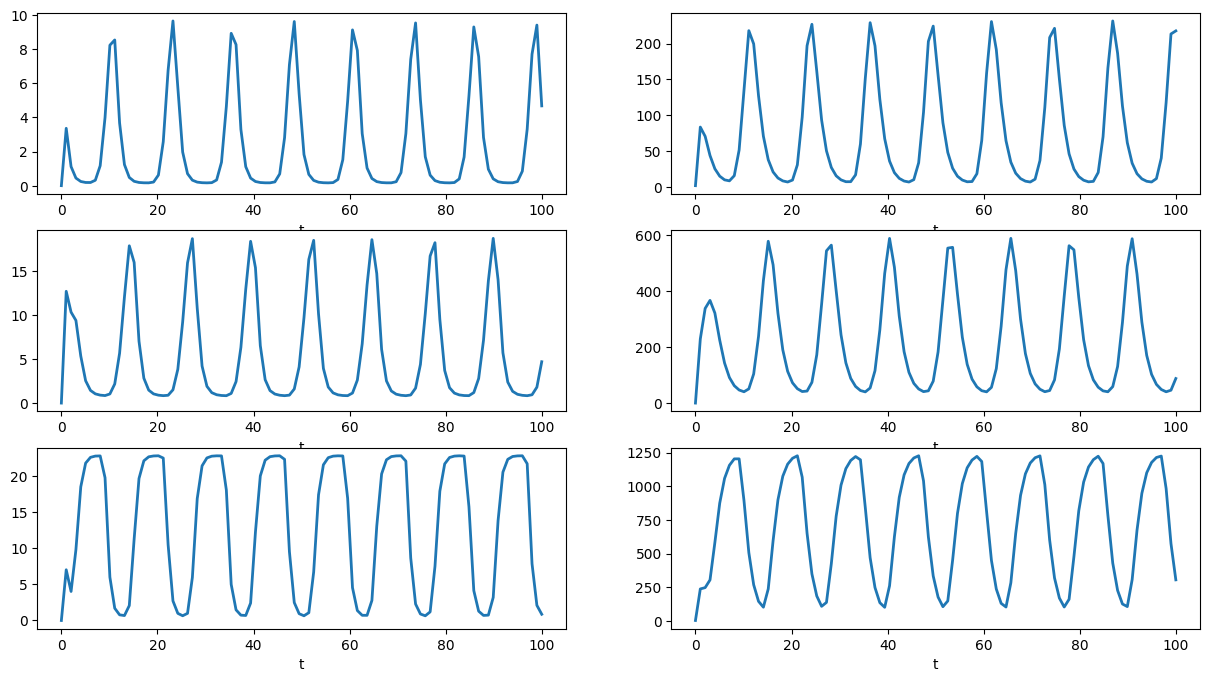

In [40]:
import matplotlib.pyplot as plt
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3, a1, a2, a3, g1, g2, g3, n1, n2, n3, b1, b2, b3, dm1, dm2, dm3, dp1, dp2, dp3=params
    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt])

tryplot = odeint(model, initial_conditions, t, args=(true_params_list[0],))
fig, axs = plt.subplots(3,2, figsize=(15, 8))
axs = axs.flatten()

variable_labels = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
t=np.linspace(0,100,100)
for i in range(6):
    axs[i].plot(t, tryplot[:, i], label='True Data', linewidth=2)
    axs[i].set_xlabel('t')
plt.show()

In [24]:
true_params_list[0]

array([2.35671198e+02, 6.23000477e+01, 2.20696298e+02, 3.71468916e+01,
       3.07670678e+01, 3.86050682e+01, 7.54076883e-01, 1.44795885e-01,
       2.43420106e+00, 4.70022357e+00, 1.69523989e+00, 4.04216440e+00,
       2.47773373e+01, 4.15743475e+01, 2.59771159e+01, 2.96541318e+00,
       1.40849614e+00, 2.24052119e+00, 7.23305337e-01, 7.19306366e-01,
       7.47461678e-01])

In [ ]:

def my_simulator_ss_noise(theta):
    def solve_ode_t(params, t):
        seed = 12
        np.random.seed(seed)
        initial_conditions = np.array([0.0, 2.0, 0.0, 1.0, 0.0, 3.0])
        solution = odeint(model, initial_conditions, t, args=(params,))
        noise = solution * 0.05
        solution += np.random.normal(0, noise)
        y = np.maximum(solution, 0)
        return y
    solution = solve_ode_t(theta, t)
    summarised_data = summarise(solution)
    #normalised_ss=normalise(summarised_data, m1, s1)
    return torch.tensor(summarised_data, dtype=torch.float32) 

true_data = my_simulator_ss_noise(true_params)

In [19]:
def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
headers = ["k1", "k2", "k3", "a1", "a2", "a3"]          # parameters to be inferred
num_timesteps = 100

t = np.linspace(0, 100, num_timesteps)

In [22]:
params_val= np.concatenate((np.random.default_rng().uniform(0.01,250,3),np.random.default_rng().uniform(20.,40.,3))).flatten()
odeint(model, initial_conditions, t, args=(params_val,)).shape

(100, 6)

In [ ]:
def model(variables, t, params): #params are the values passed in from simulate for sbi e.g. 3ks
        m1, p1, m2, p2, m3, p3 = variables
        param=['k1','k2','k3','a1','a2','a3','g1','g2','g3','n1','n2','n3','b1','b2','b3','dm1','dm2','dm3','dp1','dp2','dp3'] #is there way to change this
        param_values=np.concatenate([params, true_param_values[num_parameters:]])
        param_dict = dict(zip(param, param_values))
        k1, k2, k3, a1, a2, a3, g1, g2, g3, n1, n2, n3, b1, b2, b3, dm1, dm2, dm3, dp1, dp2, dp3 = [param_dict[key] for key in param]
        #for now we are setting a, g, n, b dm, dp to be constant
        dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
        dp1dt = (b1*m1) - (dp1*p1)
        dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
        dp2dt = (b2*m2) - (dp2*p2)
        dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
        dp3dt = (b3*m3)-(dp3*p3)
        return np.array([dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]).flatten()

In [68]:
headers = ["k1", "k2", "k3", "a1", "a2", "a3"]          # parameters to be inferred
num_timesteps = 100

t = np.linspace(0, 100, num_timesteps)

new_param_dict = {}
for param in all_params:
    if param not in headers:
        new_param_dict[param] = param_dict[param][4]
    elif param in headers:
        new_param_dict[param] = param

def my_simulator(theta):
    def model(variables, t, theta, new_param_dict = new_param_dict):
        m1, p1, m2, p2, m3, p3 = variables
        for i in range(len(headers)):
            new_param_dict[headers[i]] = theta[i]
        
        dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
        dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
        dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
        dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
        dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
        dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

        return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

    def solve_ode(theta, t):
        initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
        y = odeint(model, initial_conditions, t, args=(theta,))
        return y
    return solve_ode(theta, t)

true_params = tuple(param_dict[parameter] for parameter in headers)

def model(variables, t, theta, new_param_dict = new_param_dict):
    m1, p1, m2, p2, m3, p3 = variables
    for i in range(len(headers)):
        new_param_dict[headers[i]] = theta[i]
    
    dm1dt = -new_param_dict['dm1']*m1 + (new_param_dict['a1'] / (1 + ((1/new_param_dict['k1']) * p2)**new_param_dict['n1'])) + new_param_dict['g1']
    dp1dt = (new_param_dict['b1']*m1) - (new_param_dict['dp1']*p1)
    dm2dt = -new_param_dict['dm2']*m2 + (new_param_dict['a2'] / (1 + ((1/new_param_dict['k2']) * p3)**new_param_dict['n2'])) + new_param_dict['g2']
    dp2dt = (new_param_dict['b2']*m2) - (new_param_dict['dp2']*p2)
    dm3dt = -new_param_dict['dm3']*m3 + (new_param_dict['a3'] / (1 + ((1/new_param_dict['k3']) * p1)**new_param_dict['n3'])) + new_param_dict['g3']
    dp3dt = (new_param_dict['b3']*m3) - (new_param_dict['dp3']*p3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

def solve_ode(theta, t):
    initial_conditions = np.array([0, 2, 0, 1, 0, 3], dtype=np.float32)
    y = odeint(model, initial_conditions, t, args=(theta,))
    return y

In [70]:
params_val= np.concatenate((np.random.default_rng().uniform(0.01,250,3),np.random.default_rng().uniform(20.,40.,3))).flatten()
simulated_data= odeint(model, initial_conditions, t, args=(params_val,))

In [72]:
theta = []
for i in range(len(headers)):
    print(new_param_dict[headers[i]])


11.48744707139932
28.71553524696579
26.080354578625396
38.54421380541858
20.352201306033766
26.999850854599227


In [61]:
def solve_ode_t(params, t):
        seed = 12
        np.random.seed(seed)
        initial_conditions = np.array([0.0, 2.0, 0.0, 1.0, 0.0, 3.0])
        solution = odeint(model, initial_conditions, t, args=(params,))
        noise = solution * 0.05
        solution += np.random.normal(0, noise)
        y = np.maximum(solution, 0)
        return y #convert to np
solution = solve_ode_t(true_params, t)

TypeError: unsupported operand type(s) for /: 'int' and 'str'

In [26]:
sol = solution.T.flatten().numpy()
sol

array([0.00000000e+00, 3.36356902e+00, 1.17664826e+00, 4.21751112e-01,
       2.30523422e-01, 1.81770474e-01, 1.75717935e-01, 3.39282811e-01,
       9.85224783e-01, 4.19669485e+00, 8.62473297e+00, 7.89057350e+00,
       3.93403077e+00, 1.19983709e+00, 5.24520934e-01, 2.49810964e-01,
       1.95737556e-01, 1.67931661e-01, 1.90989420e-01, 2.15997919e-01,
       6.69153571e-01, 2.51531434e+00, 6.81092787e+00, 9.30350494e+00,
       5.95591116e+00, 1.78996122e+00, 7.28076100e-01, 3.30635220e-01,
       1.98125899e-01, 1.72352567e-01, 1.56248733e-01, 1.81706384e-01,
       3.13324004e-01, 1.30822814e+00, 4.94596672e+00, 9.63350105e+00,
       7.93527222e+00, 3.35793495e+00, 1.02159250e+00, 4.53896791e-01,
       2.46504903e-01, 1.96127087e-01, 1.62614822e-01, 1.72048867e-01,
       2.20651388e-01, 7.45105267e-01, 2.81920195e+00, 6.95321655e+00,
       9.31938076e+00, 5.55005264e+00, 1.88865864e+00, 6.66251838e-01,
       3.05423588e-01, 2.10846260e-01, 1.94110170e-01, 1.61097437e-01,
      

In [35]:
solution

array([[0.00000000e+00, 1.93185741e+00, 0.00000000e+00, 9.14963218e-01,
        0.00000000e+00, 2.76979180e+00],
       [3.36356913e+00, 8.31211016e+01, 1.21762779e+01, 2.62135091e+02,
        6.82595847e+00, 2.42951054e+02],
       [1.17664822e+00, 6.64289066e+01, 1.10155609e+01, 3.35697975e+02,
        4.22950757e+00, 2.35735434e+02],
       [4.21751117e-01, 4.66267777e+01, 9.61637118e+00, 3.68910766e+02,
        1.01447895e+01, 3.12245879e+02],
       [2.30523427e-01, 2.26846546e+01, 4.89070173e+00, 2.92624259e+02,
        1.64842447e+01, 5.62856165e+02],
       [1.81770478e-01, 1.51938762e+01, 2.56174314e+00, 2.20598645e+02,
        2.15555513e+01, 8.77297260e+02],
       [1.75717935e-01, 9.73406589e+00, 1.44016253e+00, 1.38522047e+02,
        2.19862157e+01, 1.05277073e+03],
       [3.39282823e-01, 8.85136566e+00, 1.02872404e+00, 8.91452902e+01,
        2.26778166e+01, 1.28496083e+03],
       [9.85224801e-01, 1.63193980e+01, 9.12759208e-01, 6.56034708e+01,
        2.15205800e+01, 

In [37]:
np.corrcoef(solution, solution, rowvar=False)

array([[ 1.        ,  0.78578311, -0.32700643, -0.56465825, -0.49769162,
        -0.0108105 ,  1.        ,  0.78578311, -0.32700643, -0.56465825,
        -0.49769162, -0.0108105 ],
       [ 0.78578311,  1.        ,  0.07199195, -0.33005079, -0.83192728,
        -0.48770143,  0.78578311,  1.        ,  0.07199195, -0.33005079,
        -0.83192728, -0.48770143],
       [-0.32700643,  0.07199195,  1.        ,  0.78540042, -0.50198605,
        -0.81097596, -0.32700643,  0.07199195,  1.        ,  0.78540042,
        -0.50198605, -0.81097596],
       [-0.56465825, -0.33005079,  0.78540042,  1.        , -0.02286287,
        -0.53005656, -0.56465825, -0.33005079,  0.78540042,  1.        ,
        -0.02286287, -0.53005656],
       [-0.49769162, -0.83192728, -0.50198605, -0.02286287,  1.        ,
         0.81856743, -0.49769162, -0.83192728, -0.50198605, -0.02286287,
         1.        ,  0.81856743],
       [-0.0108105 , -0.48770143, -0.81097596, -0.53005656,  0.81856743,
         1.        , -